# Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: `Geraldine Coli Acevedo`, `Carlos Olguín`, `René Saavedra Vargas`.  

## 1. Introducción

El siguiente cuaderno presenta un avance de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realizan evaluaciones de modelos de recomendación sobre un conjunto de datos de ratings de Steam. 

Para ejecutar este cuaderno, es necesario descargar los archivos y descomprimirlos en la carpeta `data/`.

## 2. Inicialización del proyecto

### 2.1. Importación de librerías

In [1]:
# Librerias estándar
import json
import time
from collections import Counter, defaultdict
from math import log2

# Datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch y PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

# LightFM
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# Evaluación de modelos
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    novelty,
    diversity,
    recall_at_k,
    precision_at_k
)
from recommenders.models.lightfm.lightfm_utils import (
    prepare_test_df,
    prepare_all_predictions
)
from recommenders.utils.timer import Timer


C:\Users\René\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\René\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### 2.2. Cargar datos

In [2]:
games_path   = 'data/games.csv'
games_metadata_path = 'data/games_metadata.json'
users_path =  'data/users.csv'
recommendations_path =  'data/recommendations.csv'

In [3]:
# CUDA se queda sin memoria con el 100% (CUDA tried to allocate X GiB), se utiliza frac = 0.333 o menos
FRACTION = 0.1

games_df = pd.read_csv(games_path)
games_df = games_df.sample(frac=FRACTION, random_state=42)
users_df = pd.read_csv(users_path)
recommendations_df = pd.read_csv(recommendations_path)
recommendations_df = recommendations_df.sample(frac=FRACTION, random_state=42)

games_metadata = []
with open(games_metadata_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            games_metadata.append(json.loads(line))

games_metadata_df = pd.DataFrame(games_metadata)
print(games_metadata_df.head())


   app_id                                        description  \
0   13500  Enter the dark underworld of Prince of Persia ...   
1   22364                                                      
2  113020  Monaco: What's Yours Is Mine is a single playe...   
3  226560  Escape Dead Island is a Survival-Mystery adven...   
4  249050  Dungeon of the Endless is a Rogue-Like Dungeon...   

                                                tags  
0  [Action, Adventure, Parkour, Third Person, Gre...  
1                                           [Action]  
2  [Co-op, Stealth, Indie, Heist, Local Co-Op, St...  
3  [Zombies, Adventure, Survival, Action, Third P...  
4  [Roguelike, Strategy, Tower Defense, Pixel Gra...  


In [4]:
print(games_df.columns)
print(users_df.columns)
print(recommendations_df.columns)
print(games_metadata_df.columns)

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')
Index(['user_id', 'products', 'reviews'], dtype='object')
Index(['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours',
       'user_id', 'review_id'],
      dtype='object')
Index(['app_id', 'description', 'tags'], dtype='object')


Para formato adecuado lightFM y modelos asociados.

In [5]:
games_df = games_df.rename(columns={
    'app_id': 'itemID'
})
users_df = users_df.rename(columns={
    'user_id': 'userID'

})
recommendations_df = recommendations_df.rename(columns={
    'app_id': 'itemID',
    'user_id':"userID",
    'review_id':'reviewID'
})

games_metadata_df = games_metadata_df.rename(columns={
    'app_id': 'itemID'
})

In [6]:
tags = games_metadata_df['tags']

all_tags = [tag for sublist in tags if sublist for tag in sublist]

unique_tags = list(set(all_tags))
tag_counts = Counter(all_tags)

tags_df = pd.DataFrame({
    'tag': list(tag_counts.keys()),
    'count': list(tag_counts.values())
}).sort_values('count', ascending=False)

print(tags_df.head(10))

             tag  count
22         Indie  27957
5   Singleplayer  22566
0         Action  21897
1      Adventure  20183
30        Casual  17844
68    Simulation  12691
33            2D  11438
25      Strategy  11093
44           RPG  10156
8    Atmospheric   8688


### 2.3. Creación del dataframe

In [9]:
# Utilizamos estos valores para filtrar los usuarios y juegos, en LightGCN se hace una evaluación de este párametro

MIN_REVIEWS_USER = 150
MIN_REVIEWS_ITEM = 200

def generate_dfs(min_reviews_user, min_reviews_item, verbose=True):
    active_users = users_df[users_df['reviews'] >= min_reviews_user]['userID']

    popular_items = games_df[games_df['user_reviews'] >= min_reviews_item]['itemID']

    filtered_recommendations = recommendations_df[
        recommendations_df['userID'].isin(active_users) &
        recommendations_df['itemID'].isin(popular_items)
    ].copy()

    games_filtered = games_df[games_df['itemID'].isin(popular_items)]
    df_merged = pd.merge(
        filtered_recommendations,
        games_filtered,
        on='itemID',
        how='left'
    )

    df_merged = pd.merge(
        df_merged,
        games_metadata_df,
        on='itemID',
        how='left'
    )

    users_filtered = users_df[users_df['userID'].isin(active_users)]

    df_merged = pd.merge(
        df_merged,
        users_filtered,
        on='userID',
        how='left'
    )

    if verbose:
        print(f"Dimensiones finales: {df_merged.shape}")
        print(f"Usuarios únicos: {df_merged['userID'].nunique()}")
        print(f"Juegos únicos: {df_merged['itemID'].nunique()}")
        print("\nPrimeras filas:")
        print(df_merged.head(3))

    df_merged = df_merged[df_merged['tags'].apply(lambda x: len(x) > 0)]
    if verbose:
        print(df_merged.columns)

    columns_to_drop = [
        'price_original',
        'discount',
        'steam_deck',
        'description',
        'date_release',
        'price_final',
        'products',
        'helpful',
        'funny',
        'date'
    ]

    existing_columns = [col for col in columns_to_drop if col in df_merged.columns]

    df_merged = df_merged.drop(columns=existing_columns)
    if verbose:
        print(f"Columnas después de eliminar: {df_merged.columns}")
        print(f"Dimensiones finales después de eliminar columnas: {df_merged.shape}")
    return df_merged

df_merged = generate_dfs(MIN_REVIEWS_USER, MIN_REVIEWS_ITEM)

Dimensiones finales: (7211, 24)
Usuarios únicos: 2824
Juegos únicos: 923

Primeras filas:
    itemID  helpful  funny        date  is_recommended  hours   userID  \
0    40980        2      0  2018-09-07           False   43.1  9029886   
1  1202900        5      0  2022-01-30            True    2.1  5346670   
2   698780        0      0  2018-06-11            True    5.9  7875837   

   reviewID                              title date_release  ...  \
0  19368631  Stronghold Legends: Steam Edition   2016-09-15  ...   
1  30173752                 Assemble with Care   2020-03-26  ...   
2  29202122         Doki Doki Literature Club!   2017-10-06  ...   

   positive_ratio  user_reviews  price_final price_original  discount  \
0              86          1541        14.99          14.99       0.0   
1              91          3140         7.99           7.99       0.0   
2              96        184949         0.00           0.00       0.0   

   steam_deck                                  

In [10]:
print(df_merged['rating'].unique())

['Very Positive' 'Overwhelmingly Positive' 'Mostly Positive' 'Mixed'
 'Mostly Negative' 'Overwhelmingly Negative']


### 2.4. Creación de interacciones (para LightGCN)

In [11]:
def create_interactions(df):
    interactions = df[['userID', 'itemID', 'is_recommended']].copy()

    user_ids = interactions['userID'].unique()
    item_ids = interactions['itemID'].unique()
    user2idx = {u: i for i, u in enumerate(user_ids)}
    item2idx = {i: j + len(user_ids) for j, i in enumerate(item_ids)}
    num_users = len(user_ids)
    num_items = len(item_ids)
    
    return interactions, user2idx, item2idx, num_users, num_items

In [12]:
interactions, user2idx, item2idx, num_users, num_items = create_interactions(df_merged)

## 3. Modelos de recomendación

### 3.1. LightFM

Creación de las _features_ de usuario y juegos.

In [ ]:
user_features = df_merged.groupby('userID').agg({
    'hours': 'mean',
    'reviews': 'count'
}).reset_index()


scaler = MinMaxScaler()
user_features[['hours', 'reviews']] = scaler.fit_transform(user_features[['hours', 'reviews']])


item_features = df_merged.groupby('itemID').first().reset_index()

# Mapeo de ratings
rating_map = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Mostly Negative': 2,
    'Negative': 2,
    'Mixed': 3,
    'Mostly Positive': 4,
    'Very Positive': 5,
    'Overwhelmingly Positive': 6
}

item_features['rating'] = item_features['rating'].map(rating_map)

if isinstance(item_features['tags'].iloc[0], str):
    item_features['tags'] = item_features['tags'].str.strip("[]").str.replace("'", "").str.split(", ")

mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(item_features['tags'])
tag_features = [f"{x}" for x in mlb.classes_]  #

item_features['positive_ratio'] = scaler.fit_transform(item_features[['positive_ratio']])
item_features['user_reviews'] = scaler.fit_transform(item_features[['user_reviews']])


In [ ]:
dataset = Dataset()

user_feature_names = ['hours', 'reviews']
platform_feature_names = ['win', 'mac', 'linux']
item_feature_names = ['user_reviews', 'rating', 'positive_ratio'] + platform_feature_names + tag_features

dataset.fit(
    users=df_merged['userID'].unique(),
    items=df_merged['itemID'].unique(),
    user_features=user_feature_names,
    item_features=item_feature_names
)


def build_user_features(row):
    return (row['userID'], {'hours': float(row['hours']), 'reviews': float(row['reviews'])})

user_features_list = [build_user_features(row) for _, row in user_features.iterrows()]
user_features_matrix = dataset.build_user_features(user_features_list)


def build_item_features(row):
    features = {
        'user_reviews': float(row['user_reviews']),
        'rating': int(row['rating']),
        'positive_ratio': float(row['positive_ratio']),
        'win': float(row['win']),    #
        'mac': float(row['mac']),
        'linux': float(row['linux'])
    }

    # Codificar cada genero
    for i, tag in enumerate(mlb.classes_):
        if tags_encoded[row.name, i]:
            features[f'{tag}'] = 1.0

    return (row['itemID'], features)

item_features_list = [build_item_features(row) for _, row in item_features.iterrows()]
item_features_matrix = dataset.build_item_features(item_features_list)

interactions, weights = dataset.build_interactions(
    (row['userID'], row['itemID'], float(row['is_recommended']))
    for _, row in df_merged.iterrows()
)

Se utiliza `calculate_fast_metrics` para agilizar la evaluación de LightFM, esto dado que cada entrenamiento toma entre 30 a 60 minutos. 

In [ ]:
def calculate_fast_metrics(test_df, predictions, train_interactions, item_popularity, item_features_matrix, iid_map, k=10):

    predictions = predictions[predictions['userID'].isin(test_df['userID'])]

    merged = test_df.merge(predictions, on=['userID', 'itemID'], how='left', suffixes=('_true', '_pred'))

    metrics = {
        'Precision@K': precision_at_k(test_df, predictions, k=k),
        'Recall@K': recall_at_k(test_df, predictions, k=k),
        'MAP@K': map_at_k(test_df, predictions, k=k),
        'NDCG@K': ndcg_at_k(test_df, predictions, k=k)
    }

    top_items = predictions['itemID'].value_counts().index[:k]
    metrics['Popularity'] = np.mean([item_popularity.get(item, 0) for item in top_items]) if len(top_items) > 0 else 0

    if len(test_df) < 10000:
        try:
            rows, cols = train_interactions.nonzero()
            train_df = pd.DataFrame({'userID': rows, 'itemID': cols})
            metrics['Novelty'] = novelty(train_df=train_df, reco_df=predictions)

            user_recs = predictions.groupby('userID')['itemID'].apply(list).to_dict()
            diversity_data = []
            for user, items in user_recs.items():
                diversity_data.extend([{'userID': user, 'itemID': item, 'rank': i+1}
                                    for i, item in enumerate(items[:k])])

            metrics['Diversity'] = diversity(
                train_df=train_df,
                reco_df=pd.DataFrame(diversity_data),
            )
        except Exception as e:
            print(f"Error calculando métricas avanzadas: {e}")
            metrics.update({'Novelty': np.nan, 'Diversity': np.nan})

    return metrics

In [ ]:
# Test correcto flujo
K = 10
TEST_PERCENTAGE = 0.2
#LEARNING_RATE = 0.05
#NO_COMPONENTS = 64
#NO_EPOCHS = 50
NO_THREADS = 4
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6
SEED = 42
SAMPLE_FRAC = 0.3

0.05, 100, 128

for LEARNING_RATE in [0.05]:
  for NO_EPOCHS in [100]:
    for NO_COMPONENTS in [128]:

      train, test = cross_validation.random_train_test_split(
                      interactions,
                      test_percentage=TEST_PERCENTAGE,
                      random_state=np.random.RandomState(SEED)
        )

      model = LightFM(
            no_components=NO_COMPONENTS,
            learning_rate=LEARNING_RATE,
            item_alpha=ITEM_ALPHA,
            user_alpha=USER_ALPHA,
            random_state=np.random.RandomState(SEED)
        )


      with Timer() as t:
          model.fit(
              interactions=train,
              user_features=user_features_matrix,
              item_features=item_features_matrix,
              epochs=NO_EPOCHS,
              num_threads=NO_THREADS
            )

      print(f"Entrenamiento: {t.interval:.1f}s")

      uids, iids, interaction_data = cross_validation._shuffle(
        interactions.row,
        interactions.col,
        interactions.data,
        random_state=np.random.RandomState(SEED)
      )

      cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
      test_idx = slice(cutoff, None)
      uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()


      with Timer() as t:

          test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)

          all_preds = prepare_all_predictions(
                test_df, uid_map, iid_map,
                interactions=train,
                user_features=user_features_matrix,
                item_features=item_features_matrix,
                model=model,
                num_threads=NO_THREADS
            )

      print(f"Predicción: {t.interval:.1f}s")

      item_popularity = defaultdict(int)
      rows, cols = train.nonzero()

      for item_idx in cols:
          try:
              item_id = iid_map[item_idx]
              item_popularity[item_id] += 1
          except KeyError:
              continue  # Saltar ítems no mapeados

      metrics = calculate_fast_metrics(
            test_df=test_df,
            predictions=all_preds,
            train_interactions=train,
            item_popularity=item_popularity,
            item_features_matrix=item_features_matrix,
            iid_map=iid_map,
            k=K
        )

      result = {
            'LR': LEARNING_RATE,
            'Epochs': NO_EPOCHS,
            'Components': NO_COMPONENTS,
            **metrics
        }

      print("Métricas:")
      for k, v in metrics.items():
          print(f"{k}: {v:.4f}")

Entrenamiento: 68.4s
Predicción: 39.1s
Métricas:
Precision@K: 0.0018
Recall@K: 0.0135
MAP@K: 0.0027
NDCG@K: 0.0055
Popularity: 0.0000
Novelty: 0.0493
Diversity: 1.0000


C:\Users\René\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:1435: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_novelty = reco_item_novelty.agg({"product": "sum"})[0] / n_recommendations
C:\Users\René\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\recommenders\evaluation\python_evaluation.py:1233: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

### 3.2. Baselines

Most Popular y Random

In [1]:
print(df_merged)
rating_map = {
    'Overwhelmingly Negative': 0,
    'Very Negative': 1,
    'Mostly Negative': 2,
    'Negative': 2,
    'Mixed': 3,
    'Mostly Positive': 4,
    'Very Positive': 5,
    'Overwhelmingly Positive': 6
}
df_merged['rating'] = df_merged['rating'].map(rating_map)

print(df_merged)

NameError: name 'df_merged' is not defined

In [48]:
K = 10
pop_counts = (
    df_merged[df_merged['rating'].astype(float) >= 4]
    .groupby('itemID')
    .size()
    .reset_index(name='pos_count')
)
top_popular_items = (
    pop_counts.sort_values(by='pos_count', ascending=False)
    .head(K)['itemID']
    .tolist()
)

# 2. Recommend same top-K items to every user
def recommend_popular(user_id, k=10):
    return top_popular_items[:k]

In [ ]:
def ndcg_at_k_pop(recommended, ground_truth, k=10):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth:
            dcg += 1.0 / log2(i + 2)
    ideal = sum(1.0 / log2(i + 2) for i in range(min(len(ground_truth), k)))
    return dcg / ideal if ideal > 0 else 0.0

def ap_at_k_pop(recommended, ground_truth, k=10):
    hits, score = 0, 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(ground_truth), k) if ground_truth else 0.0

def diversity_at_k_pop(recommended, embeddings, k=10):
    sims = []
    for i in range(min(k, len(recommended))):
        for j in range(i + 1, min(k, len(recommended))):
            idx_i = item2idx[recommended[i]]
            idx_j = item2idx[recommended[j]]
            vi = embeddings[idx_i]
            vj = embeddings[idx_j]
            sims.append((vi @ vj) / (vi.norm() * vj.norm()))
    return 1 - float(np.mean(sims)) if sims else 0.0

def novelty_at_k_pop(recommended, pop_counts, total_interactions, k=10):
    scores = []
    for item in recommended[:k]:
        pc = pop_counts.get(item, 1)
        scores.append(-log2(pc / total_interactions))
    return float(np.mean(scores))


In [ ]:
K = 10
top_popular_items = pop_counts.sort_values(ascending=False, by='pos_count').head(K)['itemID'].tolist()

def recommend_popular(user_id, k=10):
    return top_popular_items[:k]

def recommend_random(user_id, k=10):
    return np.random.choice(df_merged['itemID'].unique(), size=k, replace=False).tolist()

results_popular = []
results_random = []
user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()

for user_id, gt_items in user_gt.items():
    recs = recommend_popular(user_id, k=K)
    recs_random = recommend_random(user_id, k=K)
    
    results_random.append({
        'user': user_id,
        'ndcg': ndcg_at_k_pop(recs_random, gt_items),
        'map': ap_at_k_pop(recs_random, gt_items),
        'diversity': diversity_at_k_pop(recs_random, emb_matrix, k=K),
        'novelty': novelty_at_k_pop(recs_random, pop_counts, total_interactions, k=K)
    })
    results_popular.append({
        'user': user_id,
        'ndcg': ndcg_at_k_pop(recs, gt_items),
        'map': ap_at_k_pop(recs, gt_items),
        'diversity': diversity_at_k_pop(recs, emb_matrix, k=K),
        'novelty': novelty_at_k_pop(recs, pop_counts, total_interactions, k=K)
    })

df_popular_metrics = pd.DataFrame(results_popular)
avg_popular_metrics = df_popular_metrics.mean().round(4)

print("Popular:")
print(avg_popular_metrics.round(3).to_string())

df_random_metrics = pd.DataFrame(results_random)
avg_random_metrics = df_random_metrics.mean().round(4)

print("Random:")
print(avg_random_metrics.round(3).to_string())



📊 Popular Recommender Metrics:
user         7972224.054
ndcg               0.051
map                0.034
diversity          0.894
novelty           11.872
📊 Random Recommender Metrics:
user         7972224.054
ndcg               0.005
map                0.004
diversity          0.994
novelty           11.872


### 3.3. LightGCN

In [13]:
def create_edge_index(interactions, user2idx, item2idx):
    edges = interactions[interactions['is_recommended'] == True]
    src = edges['userID'].map(user2idx).to_numpy()
    tgt = edges['itemID'].map(item2idx).to_numpy()
    edge_index = torch.tensor([src, tgt], dtype=torch.long)
    
    return edges, edge_index

edges, edge_index = create_edge_index(interactions, user2idx, item2idx)

C:\Users\René\AppData\Local\Temp\ipykernel_11396\3532474919.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_index = torch.tensor([src, tgt], dtype=torch.long)


In [14]:
def build_lightgcn_edge(edge_index, num_nodes):
    rev = edge_index.flip(0)
    edge_index_sym = torch.cat([edge_index, rev], dim=1)

    edge_index_sym, _ = add_self_loops(edge_index_sym, num_nodes=num_nodes)
    row, col = edge_index_sym

    deg = degree(row, num_nodes, dtype=torch.float)
    deg_inv_sqrt = deg.pow(-0.5)
    norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
    return edge_index_sym, norm

In [15]:
data = Data(num_nodes=num_users + num_items, edge_index=edge_index)

Capa de convolución de Grafos


In [16]:
class LightGCNConv(MessagePassing):
    def forward(self, x, edge_index, norm):
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

In [17]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, embed_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, embed_dim)
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(num_layers)])

    def forward(self, data):
        x = self.embedding.weight
        edge_index_sym, norm = build_lightgcn_edge(data.edge_index, x.size(0))
        emb_list = [x]
        for conv in self.convs:
            x = conv(x, edge_index_sym, norm)
            emb_list.append(x)
        return torch.stack(emb_list, dim=1).mean(dim=1)

def bpr_loss(emb, users, pos, neg):
    u = emb[users]; i = emb[pos]; j = emb[neg]
    return -F.logsigmoid((u * i).sum(-1) - (u * j).sum(-1)).mean()

In [18]:
train_e, test_e = train_test_split(edges, test_size=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightGCN(num_users + num_items, embed_dim=64, num_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = data.to(device)

#### Análisis de sensibilidad respecto a hiperparámetros

In [19]:
embed_dims    = [64, 128, 256]
num_layers_ls = [2, 3, 5]
learning_rates = [0.001, 0.005, 0.01] 

models_gcn = {}

for d in embed_dims:
    for L in num_layers_ls:
        for lr in learning_rates:
            key = f"dim{d}_layers{L}_lr{lr}"
            print(f"Training model {key}")
            
            # Instantiate a new model for this configuration
            model = LightGCN(
                num_users + num_items,
                embed_dim=d,
                num_layers=L
            ).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            
            # Training loop
            model.train()
            for epoch in range(1, 51):
                optimizer.zero_grad()
                emb   = model(data)
                batch = train_e.sample(n=1024)
                users = torch.tensor(batch['userID'].map(user2idx).to_numpy(), device=device)
                pos   = torch.tensor(batch['itemID'].map(item2idx).to_numpy(), device=device)
                neg   = torch.randint(num_users, num_users + num_items, users.shape, device=device)
                loss  = bpr_loss(emb, users, pos, neg)
                loss.backward()
                optimizer.step()
                if epoch % 10 == 0:
                    print(f"  Epoch {epoch}: Loss={loss.item():.4f}")
            
            # Save the trained model
            models_gcn[key] = model


Training model dim64_layers2_lr0.001
  Epoch 10: Loss=0.2475
  Epoch 20: Loss=0.2307
  Epoch 30: Loss=0.2467
  Epoch 40: Loss=0.1921
  Epoch 50: Loss=0.2338
Training model dim64_layers2_lr0.005
  Epoch 10: Loss=0.2446
  Epoch 20: Loss=0.1565
  Epoch 30: Loss=0.1702
  Epoch 40: Loss=0.1270
  Epoch 50: Loss=0.1008
Training model dim64_layers2_lr0.01
  Epoch 10: Loss=0.1714
  Epoch 20: Loss=0.1384
  Epoch 30: Loss=0.0844
  Epoch 40: Loss=0.0662
  Epoch 50: Loss=0.0335
Training model dim64_layers3_lr0.001
  Epoch 10: Loss=0.1968
  Epoch 20: Loss=0.1646
  Epoch 30: Loss=0.1528
  Epoch 40: Loss=0.1540
  Epoch 50: Loss=0.1353
Training model dim64_layers3_lr0.005
  Epoch 10: Loss=0.1428
  Epoch 20: Loss=0.1074
  Epoch 30: Loss=0.0868
  Epoch 40: Loss=0.0681
  Epoch 50: Loss=0.0880
Training model dim64_layers3_lr0.01
  Epoch 10: Loss=0.1078
  Epoch 20: Loss=0.0889
  Epoch 30: Loss=0.0452
  Epoch 40: Loss=0.0306
  Epoch 50: Loss=0.0293
Training model dim64_layers5_lr0.001
  Epoch 10: Loss=0.1713

In [ ]:
inv_item2idx = {v: k for k, v in item2idx.items()}
def recommend(user_id, emb, k=10):
    uidx = user2idx[user_id]
    scores = emb[uidx] @ emb[num_users:].t()
    topk = torch.topk(scores, k).indices.cpu().numpy()
    return [inv_item2idx[i + num_users] for i in topk]


In [ ]:

def ndcg_at_k(recommended, ground_truth, k=10):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth:
            dcg += 1.0 / log2(i + 2)
            
    ideal = sum(1.0 / log2(i + 2) for i in range(min(len(ground_truth), k)))
    return dcg / ideal if ideal > 0 else 0.0


def ap_at_k(recommended, ground_truth, k=10):
    hits, score = 0, 0.0
    for i, item in enumerate(recommended[:k]):
        if item in ground_truth:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(ground_truth), k) if ground_truth else 0.0


def diversity_at_k(recommended, embeddings, k=10):
    sims = []
    for i in range(min(k, len(recommended))):
        for j in range(i+1, min(k, len(recommended))):
            idx_i = item2idx[recommended[i]]
            idx_j = item2idx[recommended[j]]
            vi = embeddings[idx_i]
            vj = embeddings[idx_j]
            sims.append((vi @ vj) / (vi.norm() * vj.norm()))
    return 1 - float(np.mean(sims)) if sims else 0.0


total_interactions = len(train_e)
pop_counts = train_e['itemID'].value_counts().to_dict()

def novelty_at_k(recommended, pop_counts, total_interactions, k=10):
    scores = []
    for item in recommended[:k]:
        pc = pop_counts.get(item, 1)
        scores.append(-log2(pc / total_interactions))
    return float(np.mean(scores))

In [ ]:

summary = []

for key, model in models_gcn.items():
    model.eval()
    emb_matrix = model(data).detach().cpu()
    user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()

    ndcgs, maps, divs, novs = [], [], [], []
    for user_id, gt_items in user_gt.items():
        recs = recommend(user_id, emb_matrix, k=10)
        ndcgs.append(ndcg_at_k(recs, gt_items))
        maps.append(ap_at_k(recs, gt_items))
        divs.append(diversity_at_k(recs, emb_matrix, k=10))
        novs.append(novelty_at_k(recs, pop_counts, total_interactions, k=10))

    summary.append({
        'model':    key,
        'ndcg':     sum(ndcgs) / len(ndcgs),
        'map':      sum(maps) / len(maps),
        'diversity': sum(divs) / len(divs),
        'novelty':  sum(novs) / len(novs),
    })

df_summary = pd.DataFrame(summary).set_index('model').round(4)
display(df_summary)


,ndcg,map,diversity,novelty
model,,,,
dim64_layers2_lr0.001,0.2817,0.2243,0.9057,11.1980
dim64_layers2_lr0.005,0.3396,0.2830,0.9032,11.0399
dim64_layers2_lr0.01,0.4055,0.3395,0.8994,10.6796
dim64_layers3_lr0.001,0.3364,0.2674,0.9059,11.3077
dim64_layers3_lr0.005,0.4201,0.3513,0.9019,11.0373
dim64_layers3_lr0.01,0.5244,0.4451,0.8960,10.6022
dim64_layers5_lr0.001,0.3511,0.2730,0.9132,11.4009
dim64_layers5_lr0.005,0.5101,0.4175,0.8978,10.9307
dim64_layers5_lr0.01,0.6137,0.5282,0.8827,10.2965


#### Análisis de sensibilidad respecto a cantidad de usuarios e ítems.

In [ ]:

min_users = [0, 50, 100, 150, 200]
min_items = [0, 50, 100, 150, 200]

stats = {}

for min_user in min_users:
    for min_item in min_items:
        key = f"{min_user}_{min_item}"
        stats[key] = {}

        test_df = generate_dfs(min_user, min_item, verbose=False)
        interactions, user2idx, item2idx, num_users, num_items = create_interactions(test_df)
        edges, edge_index = create_edge_index(interactions, user2idx, item2idx)
        
        test_data = Data(
            num_nodes=num_users + num_items,
            edge_index=edge_index.to(device)
        ).to(device)

        train_e, test_e = train_test_split(edges, test_size=0.2)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = LightGCN(num_users + num_items, embed_dim=256, num_layers=5).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        data = test_data.to(device)

        start_train = time.time()
        model.train()
        for epoch in range(1, 51):
            optimizer.zero_grad()
            emb = model(data)
            batch = train_e.sample(n=1024)
            users = torch.tensor(batch['userID'].map(user2idx).to_numpy(), device=device)
            pos = torch.tensor(batch['itemID'].map(item2idx).to_numpy(), device=device)
            neg = torch.randint(num_users, num_users + num_items, users.shape, device=device)
            loss = bpr_loss(emb, users, pos, neg)
            loss.backward()
            optimizer.step()
        end_train = time.time()
        stats[key]['train_time'] = end_train - start_train

        start_eval = time.time()
        model.eval()
        emb_matrix = model(data).detach().cpu()
        user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()

        ndcgs = []
        for user_id, gt_items in user_gt.items():
            user_idx = user2idx.get(user_id)
            if user_idx is None:
                continue
            scores = emb_matrix[user_idx] @ emb_matrix[num_users:].T  
            top_k_items = torch.topk(scores, k=10).indices.tolist()
            recs = [list(item2idx.keys())[i] for i in top_k_items]
            ndcgs.append(ndcg_at_k(recs, gt_items))
        end_eval = time.time()

        avg_ndcg = sum(ndcgs) / len(ndcgs) if ndcgs else 0.0
        stats[key]['eval_time'] = end_eval - start_eval
        stats[key]['ndcg'] = avg_ndcg

        print(f"Min Users: {min_user}, Min Items: {min_item}, NDCG: {avg_ndcg:.4f}, Train: {stats[key]['train_time']:.2f}s, Eval: {stats[key]['eval_time']:.2f}s")


Min Users: 0, Min Items: 0, NDCG: 0.7186, Train: 388.22s, Eval: 12.77s
Min Users: 0, Min Items: 50, NDCG: 0.7302, Train: 147.75s, Eval: 9.24s
Min Users: 0, Min Items: 100, NDCG: 0.7320, Train: 148.06s, Eval: 7.83s
Min Users: 0, Min Items: 150, NDCG: 0.7266, Train: 145.12s, Eval: 7.23s
Min Users: 0, Min Items: 200, NDCG: 0.7332, Train: 147.45s, Eval: 6.92s
Min Users: 50, Min Items: 0, NDCG: 0.7598, Train: 4.28s, Eval: 1.02s
Min Users: 50, Min Items: 50, NDCG: 0.8144, Train: 3.92s, Eval: 0.76s
Min Users: 50, Min Items: 100, NDCG: 0.8354, Train: 3.80s, Eval: 0.63s
Min Users: 50, Min Items: 150, NDCG: 0.8530, Train: 3.74s, Eval: 0.58s
Min Users: 50, Min Items: 200, NDCG: 0.8625, Train: 3.63s, Eval: 0.49s
Min Users: 100, Min Items: 0, NDCG: 0.7141, Train: 1.99s, Eval: 0.39s
Min Users: 100, Min Items: 50, NDCG: 0.7531, Train: 1.80s, Eval: 0.31s
Min Users: 100, Min Items: 100, NDCG: 0.7870, Train: 1.75s, Eval: 0.27s
Min Users: 100, Min Items: 150, NDCG: 0.8052, Train: 1.68s, Eval: 0.23s
Min U

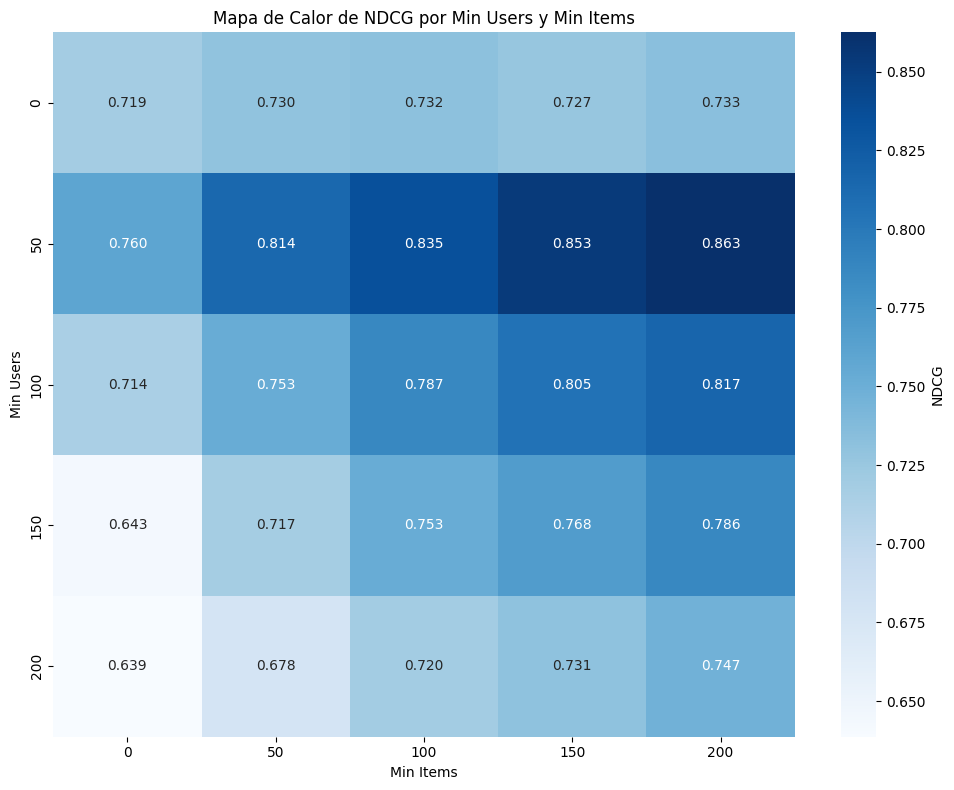

In [ ]:
min_users_sorted = sorted({int(k.split('_')[0]) for k in stats.keys()})
min_items_sorted = sorted({int(k.split('_')[1]) for k in stats.keys()})

ndcg_matrix = pd.DataFrame(index=min_users_sorted, columns=min_items_sorted)

for key, value in stats.items():
    u, i = map(int, key.split('_'))
    ndcg_matrix.at[u, i] = value['ndcg']

ndcg_matrix = ndcg_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(ndcg_matrix, annot=True, fmt=".3f", cmap="Blues", cbar_kws={'label': 'NDCG'})
plt.title("Mapa de Calor de NDCG por Min Users y Min Items")
plt.xlabel("Min Items")
plt.ylabel("Min Users")
plt.tight_layout()
plt.show()

#### Ejemplo de recomendación 

In [ ]:
def id_to_title(item_id):
    """Convierte un itemID a su título."""
    return games_df[games_df['itemID'] == item_id]['title'].values[0] if item_id in games_df['itemID'].values else "Desconocido"

random_user = np.random.choice(df_merged['userID'].unique())
seen_items = df_merged[df_merged['userID'] == random_user]['itemID'].unique()
seen_items = [id_to_title(item) for item in seen_items]

# Utilizamos el mejor modelo entrenado
best_key = "dim256_layers5_lr0.01"
model = models_gcn[best_key]
model.eval()
emb_matrix = model(data).detach().cpu()
user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()
n_users = len(user_gt)

example_recs = recommend(random_user, emb_matrix, k=5)
example_recs = [id_to_title(item) for item in example_recs]

print(f"Usuario: {random_user}")
print(f"Items vistos: {seen_items}")
print(f"Recomendaciones: {example_recs}")

Usuario: 9268011
Items vistos: ['Grim Fandango Remastered', 'Defend Your Life: TD']
Recomendaciones: ['Defend Your Life: TD', 'Grim Fandango Remastered', 'Astroflux', 'Armikrog', "Deadly Premonition: The Director's Cut"]


#### Análisis de coverage de LightGCN

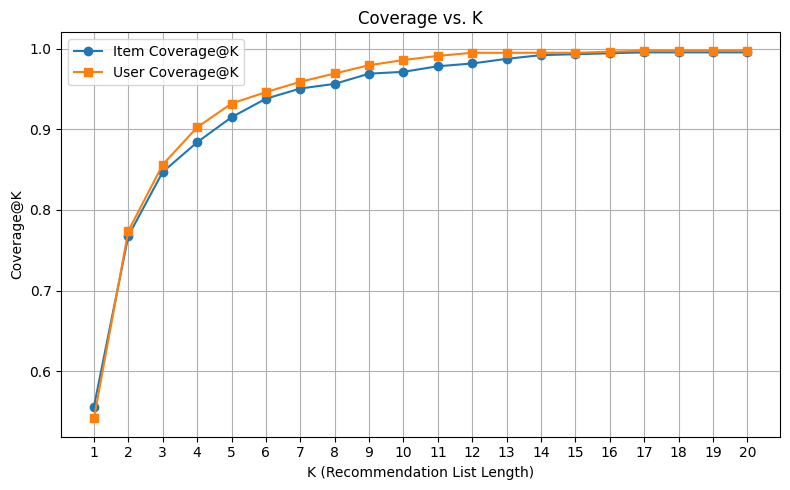

In [ ]:
Ks = list(range(1, 21))

item_coverages = []
user_coverages = []

# Utilizamos el mejor modelo entrenado
best_key = "dim256_layers5_lr0.01"
model = models_gcn[best_key]
model.eval()
emb_matrix = model(data).detach().cpu()
user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()
n_users = len(user_gt)

for K in Ks:
    all_recs = []
    hits = 0

    for user_id, gt_items in user_gt.items():
        recs = recommend(user_id, emb_matrix, k=K)
        all_recs.extend(recs)
        if any(item in gt_items for item in recs):
            hits += 1

    item_cov = len(set(all_recs)) / num_items
    user_cov = hits / n_users

    item_coverages.append(item_cov)
    user_coverages.append(user_cov)

plt.figure(figsize=(8, 5))
plt.plot(Ks, item_coverages, marker='o', label='Item Coverage@K')
plt.plot(Ks, user_coverages, marker='s', label='User Coverage@K')
plt.xlabel('K (Recommendation List Length)')
plt.ylabel('Coverage@K')
plt.title(f'Coverage vs. K')
plt.xticks(Ks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




#### Análisis de precisión y recall de LightGCN

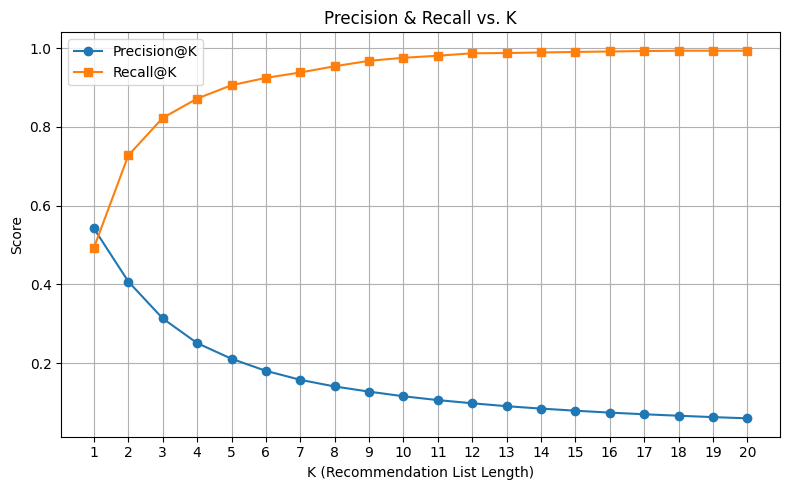

In [ ]:
Ks = list(range(1, 21))

precisions = []
recalls = []

best_key = "dim256_layers5_lr0.01"
model = models_gcn[best_key]
model.eval()
emb_matrix = model(data).detach().cpu()
user_gt = test_e.groupby('userID')['itemID'].apply(list).to_dict()
n_users = len(user_gt)

for K in Ks:
    ps, rs = [], []
    for user_id, gt_items in user_gt.items():
        recs = recommend(user_id, emb_matrix, k=K)
        # Precision@K
        hit_count = sum(1 for r in recs if r in gt_items)
        ps.append(hit_count / K)
        # Recall@K
        rs.append(hit_count / len(gt_items) if gt_items else 0.0)
    precisions.append(sum(ps) / n_users)
    recalls.append(sum(rs) / n_users)

plt.figure(figsize=(8,5))
plt.plot(Ks, precisions, marker='o', label='Precision@K')
plt.plot(Ks, recalls,    marker='s', label='Recall@K')
plt.xlabel('K (Recommendation List Length)')
plt.ylabel('Score')
plt.title(f'Precision & Recall vs. K')
plt.xticks(Ks)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
